In [1]:
# use dream_proj_env conda env
import pandas as pd
import scanpy as sc 
import os
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr, spearmanr, ttest_ind, mannwhitneyu,linregress
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random
import gseapy
from pybiomart import Dataset
import sys
import colorcet as cc
import pickle
from pylr2 import regress2

# auto reload source files
%load_ext autoreload
%autoreload 2
# add source directory to path
source_path = os.path.abspath(os.path.join('..'))
if source_path not in sys.path:
    sys.path.append(os.path.join(source_path, 'source'))
# read source files
import read_data, sc_expr_dataset, expr_dataset, utils

%config InlineBackend.figure_format = 'retina'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

magma_categorical = plt.cm.get_cmap('magma', 10)
crest_categorical = plt.cm.get_cmap('crest', 10)
coolwarm_categorical = plt.cm.get_cmap('coolwarm', 10)

# colorpalettes 
hmm = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
fred_again_again_again_palette = ['#000305', '#ff7758', '#f67805', '#d3d3d3', '#565656', '#054fff', '#f9aa74', '#5890ff']
sunset = ['#f3e79b','#fac484','#f8a07e','#eb7f86','#ce6693','#a059a0','#5c53a5']
my_continous_palette = sunset
my_categorical_palette = []
my_categorical_palette.append(hmm[3])
my_categorical_palette.append(fred_again_again_again_palette[-2])
my_categorical_palette.append(hmm[-1])
my_categorical_palette.append(fred_again_again_again_palette[-1])

my_categorical_palette.append(hmm[2])
my_categorical_palette.append(sunset[-1])
my_categorical_palette.append(sunset[-2])
my_categorical_palette.append(sunset[-5])
my_categorical_palette.append(sunset[-7])

organ_palette = {
    "Liver": my_categorical_palette[1],
    "Kidney": my_categorical_palette[2],
    "Brain": my_categorical_palette[5],
}

dream_col = 'DREAM_normalized_enrichment_score_resid'
mut_col = 'mutation_count_per_kb_top50expr'

/tmp/ipykernel_3870639/661496830.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  magma_categorical = plt.cm.get_cmap('magma', 10)
/tmp/ipykernel_3870639/661496830.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  crest_categorical = plt.cm.get_cmap('crest', 10)
/tmp/ipykernel_3870639/661496830.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  coolwarm_categorical = plt.cm.get_cmap('coolwarm', 10)


# Gene sets

In [ ]:
ensembl_to_geneSymbol = pd.read_csv('/cellar/users/zkoch/dream/utilities/ensembl_to_geneSymbol.tsv', sep = '\t', header = None)
ensembl_to_geneSymbol.columns = ['ensembl_id', 'geneSymbol']
ensembl_to_geneSymbol.set_index('ensembl_id', inplace = True)

geneSymbol_to_ensembl = ensembl_to_geneSymbol.copy()
geneSymbol_to_ensembl.reset_index(inplace = True)
geneSymbol_to_ensembl.set_index('geneSymbol', inplace = True)

# drop duplicate index values
geneSymbol_to_ensembl = geneSymbol_to_ensembl[~geneSymbol_to_ensembl.index.duplicated(keep='first')]
ensembl_to_geneSymbol = ensembl_to_geneSymbol[~ensembl_to_geneSymbol.index.duplicated(keep='first')]

# convert to uppercase
geneSymbol_to_ensembl.index = geneSymbol_to_ensembl.index.str.upper()
ensembl_to_geneSymbol['geneSymbol'] = ensembl_to_geneSymbol['geneSymbol'].str.upper()

### Expanded DREAM gene set

In [ ]:
chip_df = pd.read_excel('/cellar/users/zkoch/dream/data/litovchick_2007/mmc2.xls', header = 8)
# original 800 genes mentioned by litovchick 2007
expanded_dream_regulated_genes = chip_df.query("(ecode.str.startswith('#1111') or ecode.str.startswith('#1011'))")
# convert to gene symbols 
expanded_dream_regulated_genes['genes'] = expanded_dream_regulated_genes['5Prime_Gene'].apply(lambda x: x.split(' : ')[1].split(',')[0] if len(x.split(' : ')) > 1 else [])
expanded_dream_regulated_genes = expanded_dream_regulated_genes[expanded_dream_regulated_genes['genes'].apply(lambda x: isinstance(x, str))]

# Map gene symbols to ensembl IDs
# make genes all caps
expanded_dream_regulated_genes['genes'] = expanded_dream_regulated_genes['genes'].str.upper()
expanded_dream_regulated_genes['gene_stable_id'] = expanded_dream_regulated_genes['genes'].map(geneSymbol_to_ensembl['ensembl_id'])

expanded_dream_regulated_genes = expanded_dream_regulated_genes[['genes', 'gene_stable_id']]
expanded_dream_regulated_genes.rename(columns = {'genes': 'gene_name'}, inplace = True)
expanded_dream_regulated_genes.set_index('gene_stable_id', inplace = True)
expanded_dream_regulated_genes.to_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/litovchick_expanded_dream.csv', index = True, header = True)

/tmp/ipykernel_2897737/1403250534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expanded_dream_regulated_genes['genes'] = expanded_dream_regulated_genes['5Prime_Gene'].apply(lambda x: x.split(' : ')[1].split(',')[0] if len(x.split(' : ')) > 1 else [])


### DREAM DR & Other

In [58]:
dream_regulated_genes = utils.read_dream_files()
dream_dr =  dream_regulated_genes.query("dna_repair_genes == 1")
dream_dr = dream_dr[['gene_name']]
dream_dr['gene_name'] = dream_dr['gene_name'].str.upper()
dream_dr.to_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/dream_dr.csv', index = True, header = True)

In [60]:
dream_other = dream_regulated_genes.query("dna_repair_genes == 0")
dream_other = dream_other[['gene_name']]
dream_other['gene_name'] = dream_other['gene_name'].str.upper()
dream_other.to_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/dream_other.csv', index = True, header = True)


### Fischer et al. 2017 p53, MMB-FOXM1, RB-E2F, Expanded DREAM

In [ ]:
# from https://academic.oup.com/nar/article/44/13/6070/2457624#87025884

In [76]:
p53_targets = pd.read_excel('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/Table_S3_TP53_targets.xlsx')
p53_targets = p53_targets[['ensembl ID', 'Gene Symbol']]
p53_targets.columns = ['gene_stable_id', 'gene_name']
p53_targets['gene_name'] = p53_targets['gene_name'].str.upper()
p53_targets.set_index('gene_stable_id', inplace = True)
p53_targets.to_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/p53_targets.csv', index = True, header = True)


In [78]:
mmb_foxm1_targets = pd.read_excel('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/Table_S8_MMB-FOXM1_targets.xlsx')
mmb_foxm1_targets = mmb_foxm1_targets[['ensembl ID', 'Gene Symbol']]
mmb_foxm1_targets.columns = ['gene_stable_id', 'gene_name']
mmb_foxm1_targets['gene_name'] = mmb_foxm1_targets['gene_name'].str.upper()
mmb_foxm1_targets.set_index('gene_stable_id', inplace = True)
mmb_foxm1_targets.to_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/mmb_foxm1_targets.csv', index = True, header = True)


In [79]:
rb_e2f_targets = pd.read_excel('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/Table_S9_RB-E2F_targets.xlsx')
rb_e2f_targets = rb_e2f_targets[['ensembl ID', 'Gene Symbol']]
rb_e2f_targets.columns = ['gene_stable_id', 'gene_name']
rb_e2f_targets['gene_name'] = rb_e2f_targets['gene_name'].str.upper()
rb_e2f_targets.set_index('gene_stable_id', inplace = True)
rb_e2f_targets.to_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/rb_e2f_targets.csv', index = True, header = True)


In [ ]:
expanded_dream = pd.read_excel('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/Table_S7_DREAM_targets.xlsx')
expanded_dream = expanded_dream[['ensembl ID', 'Gene Symbol']]
expanded_dream.columns = ['gene_stable_id', 'gene_name']
expanded_dream['gene_name'] = expanded_dream['gene_name'].str.upper()
expanded_dream.set_index('gene_stable_id', inplace = True)
expanded_dream.to_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/fischer_expanded_dream.csv', index = True, header = True)

### E2F7 

In [83]:
# from https://academic.oup.com/nar/article/40/8/3511/2411136#supplementary-data supp table 6

In [88]:
e2f7_targets = pd.read_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/E2F7_targets.csv')
e2f7_targets['gene_name'] = e2f7_targets['gene_name'].str.upper()
e2f7_targets['gene_stable_id'] = e2f7_targets['gene_name'].map(geneSymbol_to_ensembl['ensembl_id'])
e2f7_targets.set_index('gene_stable_id', inplace = True)
e2f7_targets.to_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/E2F7_targets.csv', index = True, header = True)


### FOXM1

In [ ]:
# from https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/FOXM1_01.html FOXM1_01 

In [89]:
foxm1_targets = pd.read_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/FOXM1_targets.csv')
foxm1_targets['gene_name'] = foxm1_targets['gene_name'].str.upper()
foxm1_targets['gene_stable_id'] = foxm1_targets['gene_name'].map(geneSymbol_to_ensembl['ensembl_id'])
foxm1_targets.set_index('gene_stable_id', inplace = True)
foxm1_targets.to_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/FOXM1_targets.csv', index = True, header = True)


### DNMT1

In [ ]:
# from https://www.gsea-msigdb.org/gsea/msigdb/cards/JACKSON_DNMT1_TARGETS_UP?utm_source=chatgpt.com JACKSON_DNMT1_TARGETS_UP

In [90]:
dnmt1_targets = pd.read_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/DNMT1_targets.csv')
dnmt1_targets['gene_name'] = dnmt1_targets['gene_name'].str.upper()
dnmt1_targets['gene_stable_id'] = dnmt1_targets['gene_name'].map(geneSymbol_to_ensembl['ensembl_id'])
dnmt1_targets.set_index('gene_stable_id', inplace = True)
dnmt1_targets.to_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/DNMT1_targets.csv', index = True, header = True)



# Read in each set to output supp table 2

In [5]:
# read in each gene set and combine into a single dataframe
gene_sets = []

# DREAM (entire set)
dream_regulated_genes = utils.read_dream_files()
dream_full = dream_regulated_genes[['gene_name']].copy()
dream_full['gene_name'] = dream_full['gene_name'].str.upper()
dream_full['gene_set'] = 'DREAM'
gene_sets.append(dream_full)

# Expanded DREAM (Litovchick)
expanded_dream_litovchick = pd.read_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/litovchick_expanded_dream.csv', index_col=0)
expanded_dream_litovchick['gene_set'] = 'DREAM expanded (Litovchick)'
gene_sets.append(expanded_dream_litovchick)

# DREAM DR
dream_dr = pd.read_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/dream_dr.csv', index_col=0)
dream_dr['gene_set'] = 'DREAM (DNA Repair)'
gene_sets.append(dream_dr)

# DREAM Other
dream_other = pd.read_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/dream_other.csv', index_col=0)
dream_other['gene_set'] = 'DREAM (Other)'
gene_sets.append(dream_other)

# p53 targets
p53_targets = pd.read_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/p53_targets.csv', index_col=0)
p53_targets['gene_set'] = 'p53'
gene_sets.append(p53_targets)

# MMB-FOXM1 targets
mmb_foxm1_targets = pd.read_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/mmb_foxm1_targets.csv', index_col=0)
mmb_foxm1_targets['gene_set'] = 'MMB-FOXM1'
gene_sets.append(mmb_foxm1_targets)

# RB-E2F targets
rb_e2f_targets = pd.read_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/rb_e2f_targets.csv', index_col=0)
rb_e2f_targets['gene_set'] = 'RB-E2F'
gene_sets.append(rb_e2f_targets)

# Expanded DREAM (Fischer)
expanded_dream_fischer = pd.read_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/fischer_expanded_dream.csv', index_col=0)
expanded_dream_fischer['gene_set'] = 'DREAM expanded (Fischer)'
gene_sets.append(expanded_dream_fischer)

# E2F7 targets
e2f7_targets = pd.read_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/E2F7_targets.csv', index_col=0)
e2f7_targets['gene_set'] = 'E2F7'
gene_sets.append(e2f7_targets)

# FOXM1 targets
foxm1_targets = pd.read_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/FOXM1_targets.csv', index_col=0)
foxm1_targets['gene_set'] = 'FOXM1'
gene_sets.append(foxm1_targets)

# DNMT1 targets
dnmt1_targets = pd.read_csv('/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/DNMT1_targets.csv', index_col=0)
dnmt1_targets['gene_set'] = 'DNMT1'
gene_sets.append(dnmt1_targets)

# combine all gene sets into a single dataframe
all_gene_sets_df = pd.concat(gene_sets, ignore_index=False)

# reset index to make gene_stable_id a column
all_gene_sets_df.reset_index(inplace=True)
all_gene_sets_df.rename(columns={'index': 'gene_stable_id'}, inplace=True)

# reorder columns: gene_set, gene_stable_id, gene_name
all_gene_sets_df = all_gene_sets_df[['gene_set', 'gene_stable_id', 'gene_name']]

# sort by gene_set and gene_name
all_gene_sets_df = all_gene_sets_df.sort_values(['gene_set', 'gene_name'])
all_gene_sets_df.reset_index(drop=True, inplace=True)
# save to excel
output_path = '/cellar/users/zkoch/dream/figures/supplementary/supplementary_table_2.xlsx'
all_gene_sets_df.to_excel(output_path, index=False, sheet_name='Gene Sets')
print(f"Saved {len(all_gene_sets_df)} genes from {len(gene_sets)} gene sets to {output_path}")
print(f"\nGene set counts:")
print(all_gene_sets_df['gene_set'].value_counts().sort_index())


Saved 3913 genes from 11 gene sets to /cellar/users/zkoch/dream/figures/supplementary/supplementary_table_2.xlsx

Gene set counts:
gene_set
DNMT1                           81
DREAM                          328
DREAM (DNA Repair)              67
DREAM (Other)                  261
DREAM expanded (Fischer)       971
DREAM expanded (Litovchick)    769
E2F7                            89
FOXM1                          248
MMB-FOXM1                      282
RB-E2F                         506
p53                            311
Name: count, dtype: int64


In [3]:
all_gene_sets_df

,gene_set,gene_stable_id,gene_name
3505,DNMT1,ENSG00000144476,ACKR3
3520,DNMT1,ENSG00000101444,AHCY
3527,DNMT1,ENSG00000107262,BAG1
3581,DNMT1,ENSG00000136717,BIN1
3556,DNMT1,ENSG00000108691,CCL2
...,...,...,...
1362,p53,ENSG00000161642,ZNF385A
1294,p53,ENSG00000102935,ZNF423
1154,p53,ENSG00000171469,ZNF561
1388,p53,ENSG00000249709,ZNF564


# Calculate activity scores

### Cross species

In [74]:
loader = read_data.DatasetLoader("liu_2023")
liu_2023 = loader.load_dataset()
liu_2023.calc_total_seq_depth()
liu_2023.get_dream_gene_expression()
liu_2023.dream_enrichment_ssgsea()
liu_2023.scale_dream_by_seq_depth('DREAM_normalized_enrichment_score', eq='DREAM_normalized_enrichment_score ~ total_seq_depth * n_genes_expressed')

liu_2023.dream_expression.columns = [col.replace('/', '') for col in liu_2023.dream_expression.columns]

liu_2023.dream_expression['1MLyrs'] = 1/liu_2023.dream_expression['MLyrs']
liu_2023.dream_expression['1MLres'] = 1/liu_2023.dream_expression['MLres']
liu_2023.dream_expression['1AWg'] = 1/liu_2023.dream_expression['AWg']
liu_2023.dream_expression['1FTMd'] = 1/liu_2023.dream_expression['FTMd']

liu_2023.pathway_enrichment_ssgsea(
    gene_set_path='/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/DNMT1_targets.csv',
    pathway_name='DNMT1'
)
liu_2023.pathway_enrichment_ssgsea(
    gene_set_path='/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/dream_dr.csv',
    pathway_name='dream_dr'
)
liu_2023.pathway_enrichment_ssgsea(
    gene_set_path='/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/dream_other.csv',
    pathway_name='dream_other'
)
liu_2023.pathway_enrichment_ssgsea(
    gene_set_path='/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/E2F7_targets.csv',
    pathway_name='E2F7'
)
liu_2023.pathway_enrichment_ssgsea(
    gene_set_path='/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/FOXM1_targets.csv',
    pathway_name='FOXM1'
)
liu_2023.pathway_enrichment_ssgsea(
    gene_set_path='/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/fischer_expanded_dream.csv',
    pathway_name='dream_expanded_fischer'
)
liu_2023.pathway_enrichment_ssgsea(
    gene_set_path='/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/litovchick_expanded_dream.csv',
    pathway_name='dream_expanded_litovchick'
)
liu_2023.pathway_enrichment_ssgsea(
    gene_set_path='/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/mmb_foxm1_targets.csv',
    pathway_name='mmb_foxm1'
)
liu_2023.pathway_enrichment_ssgsea(
    gene_set_path='/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/p53_targets.csv',
    pathway_name='p53'
)
liu_2023.pathway_enrichment_ssgsea(
    gene_set_path='/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/rb_e2f_targets.csv',
    pathway_name='rb_e2f'
)

Loading dataset: liu_2023


2025-12-22 13:15:29,320 [INFO] Parsing data files for ssGSEA...........................


using new dream file:  False
Read in 328 DREAM genes
Did not need to convert DREAM genes
Found 289 DREAM genes with expression
scaled mean_dream_reg_expr by sequence depth and created mean_dream_reg_expr_resid
using new dream file:  False


2025-12-22 13:15:30,927 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:15:30,929 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:15:30,929 [INFO] Start to run ssGSEA...Might take a while................
2025-12-22 13:15:36,224 [INFO] Parsing data files for ssGSEA...........................


scaled DREAM_normalized_enrichment_score by sequence depth and created DREAM_normalized_enrichment_score_resid
scaled DREAM_enrichment_score by sequence depth and created DREAM_enrichment_score_resid
scaled DREAM_normalized_enrichment_score by sequence depth and created DREAM_normalized_enrichment_score_resid
Found 70 DNMT1 genes with expression


2025-12-22 13:15:37,866 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:15:37,868 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:15:37,869 [INFO] Start to run ssGSEA...Might take a while................
2025-12-22 13:15:43,194 [INFO] Parsing data files for ssGSEA...........................


Scaled DNMT1_NES by sequence depth and created DNMT1_NES_resid
Scaled DNMT1_ES by sequence depth and created DNMT1_ES_resid
Found 61 dream_dr genes with expression


2025-12-22 13:15:44,773 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:15:44,775 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:15:44,776 [INFO] Start to run ssGSEA...Might take a while................
2025-12-22 13:15:53,541 [INFO] Parsing data files for ssGSEA...........................


Scaled dream_dr_NES by sequence depth and created dream_dr_NES_resid
Scaled dream_dr_ES by sequence depth and created dream_dr_ES_resid
Found 228 dream_other genes with expression


2025-12-22 13:15:55,939 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:15:55,942 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:15:55,942 [INFO] Start to run ssGSEA...Might take a while................
2025-12-22 13:16:02,712 [INFO] Parsing data files for ssGSEA...........................


Scaled dream_other_NES by sequence depth and created dream_other_NES_resid
Scaled dream_other_ES by sequence depth and created dream_other_ES_resid
Found 77 E2F7 genes with expression


2025-12-22 13:16:04,491 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:16:04,493 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:16:04,494 [INFO] Start to run ssGSEA...Might take a while................
2025-12-22 13:16:09,749 [INFO] Parsing data files for ssGSEA...........................


Scaled E2F7_NES by sequence depth and created E2F7_NES_resid
Scaled E2F7_ES by sequence depth and created E2F7_ES_resid
Found 200 FOXM1 genes with expression


2025-12-22 13:16:11,294 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:16:11,296 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:16:11,296 [INFO] Start to run ssGSEA...Might take a while................
2025-12-22 13:16:16,713 [INFO] Parsing data files for ssGSEA...........................


Scaled FOXM1_NES by sequence depth and created FOXM1_NES_resid
Scaled FOXM1_ES by sequence depth and created FOXM1_ES_resid
Found 876 dream_expanded_fischer genes with expression


2025-12-22 13:16:18,349 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:16:18,351 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:16:18,352 [INFO] Start to run ssGSEA...Might take a while................
2025-12-22 13:16:24,554 [INFO] Parsing data files for ssGSEA...........................


Scaled dream_expanded_fischer_NES by sequence depth and created dream_expanded_fischer_NES_resid
Scaled dream_expanded_fischer_ES by sequence depth and created dream_expanded_fischer_ES_resid
Found 446 dream_expanded_litovchick genes with expression


2025-12-22 13:16:26,187 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:16:26,189 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:16:26,190 [INFO] Start to run ssGSEA...Might take a while................
2025-12-22 13:16:31,637 [INFO] Parsing data files for ssGSEA...........................


Scaled dream_expanded_litovchick_NES by sequence depth and created dream_expanded_litovchick_NES_resid
Scaled dream_expanded_litovchick_ES by sequence depth and created dream_expanded_litovchick_ES_resid
Found 239 mmb_foxm1 genes with expression


2025-12-22 13:16:33,201 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:16:33,203 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:16:33,204 [INFO] Start to run ssGSEA...Might take a while................
2025-12-22 13:16:38,842 [INFO] Parsing data files for ssGSEA...........................


Scaled mmb_foxm1_NES by sequence depth and created mmb_foxm1_NES_resid
Scaled mmb_foxm1_ES by sequence depth and created mmb_foxm1_ES_resid
Found 283 p53 genes with expression


2025-12-22 13:16:40,546 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:16:40,548 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:16:40,549 [INFO] Start to run ssGSEA...Might take a while................
2025-12-22 13:16:46,214 [INFO] Parsing data files for ssGSEA...........................


Scaled p53_NES by sequence depth and created p53_NES_resid
Scaled p53_ES by sequence depth and created p53_ES_resid
Found 469 rb_e2f genes with expression


2025-12-22 13:16:47,848 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:16:47,850 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:16:47,851 [INFO] Start to run ssGSEA...Might take a while................


Scaled rb_e2f_NES by sequence depth and created rb_e2f_NES_resid
Scaled rb_e2f_ES by sequence depth and created rb_e2f_ES_resid


In [98]:
def plot_dream_coefficients_barplot(
    results_long, 
    dream_pathways,
    solo_pathways, 
    dream_combo_pathways,
    organ='Liver', 
    figsize=(14, 5),
    dream_color=my_categorical_palette[0],
    solo_color=my_categorical_palette[1],
    combo_color=my_categorical_palette[2]
):
    """
    Plot pathway coefficients on three subplots with shared y-axis.

    Parameters:
        results_long: Long-format DataFrame from calc_aw_regression_association
        dream_pathways: List of DREAM pathways to plot (first one stays first, rest sorted by coefficient)
        solo_pathways: List of pathways to plot their own coefficient (from solo models, sorted by coefficient)
        dream_combo_pathways: List of pathways to plot DREAM's coefficient (from DREAM + pathway models, sorted by coefficient)
        organ: Which organ to plot
        figsize: Figure size tuple
        dream_color: Color for DREAM pathway bars
        solo_color: Color for solo pathway bars
        combo_color: Color for DREAM combo bars

    Returns:
        fig, axes
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=False)

    # Mapper for nice display labels
    mapper = {
        'DREAM_normalized_enrichment_score_resid': 'DREAM',
        'DNMT1_NES_resid': 'DNMT1',
        'dream_dr_NES_resid': 'DREAM (DNA Repair)', 
        'dream_other_NES_resid': 'DREAM (Other)', 
        'E2F7_NES_resid': 'E2F7',
        'FOXM1_NES_resid': 'FOXM1', 
        'dream_expanded_fischer_NES_resid': 'DREAM expanded (Fischer)',
        'dream_expanded_litovchick_NES_resid': 'DREAM expanded (Litovchick)', 
        'mmb_foxm1_NES_resid': 'MMB-FOXM1',
        'p53_NES_resid': 'p53', 
        'rb_e2f_NES_resid': 'RB-E2F'
    }

    # Helper function to clean pathway names using mapper
    def clean_name(name):
        if name in mapper:
            return mapper[name]
        return (
            name
            .replace('_NES_resid', '')
            .replace('_normalized_enrichment_score_resid', '')
            .replace('_', ' ')
        )

    # --- Collect all data first to determine y-axis range ---
    
    # DREAM pathways data
    dream_data = []
    for pathway in dream_pathways:
        row = results_long.query(
            "Organ == @organ and model_type == 'solo' and pathway == @pathway"
        )
        if len(row) > 0:
            dream_data.append({
                'pathway': pathway,
                'coef': row['coefficient'].values[0],
                'pval': row['pvalue'].values[0],
                'name': clean_name(pathway)
            })
        else:
            dream_data.append({
                'pathway': pathway,
                'coef': np.nan,
                'pval': np.nan,
                'name': clean_name(pathway)
            })
    
    if len(dream_data) > 1:
        first_pathway = dream_data[0]
        rest_pathways = sorted(dream_data[1:], key=lambda x: x['coef'] if not np.isnan(x['coef']) else float('-inf'), reverse=True)
        dream_data = [first_pathway] + rest_pathways

    # Solo pathways data
    solo_data = []
    for pathway in solo_pathways:
        row = results_long.query(
            "Organ == @organ and model_type == 'solo' and pathway == @pathway"
        )
        if len(row) > 0:
            solo_data.append({
                'pathway': pathway,
                'coef': row['coefficient'].values[0],
                'pval': row['pvalue'].values[0],
                'name': clean_name(pathway)
            })
        else:
            solo_data.append({
                'pathway': pathway,
                'coef': np.nan,
                'pval': np.nan,
                'name': clean_name(pathway)
            })
    solo_data = sorted(solo_data, key=lambda x: x['coef'] if not np.isnan(x['coef']) else float('-inf'), reverse=True)

    # Combo pathways data
    combo_data = []
    for pathway in dream_combo_pathways:
        row = results_long.query(
            "Organ == @organ and model_type == 'with_DREAM' and pathway == @pathway"
        )
        if len(row) > 0:
            combo_data.append({
                'pathway': pathway,
                'coef': row['coefficient'].values[0],
                'pval': row['pvalue'].values[0],
                'name': f"DREAM | {clean_name(pathway)}"
            })
        else:
            combo_data.append({
                'pathway': pathway,
                'coef': np.nan,
                'pval': np.nan,
                'name': f"DREAM | {clean_name(pathway)}"
            })
    combo_data = sorted(combo_data, key=lambda x: x['coef'] if not np.isnan(x['coef']) else float('-inf'), reverse=True)

    # Collect all coefficients to determine global y-axis limits
    all_coefs = ([d['coef'] for d in dream_data] + 
                 [d['coef'] for d in solo_data] + 
                 [d['coef'] for d in combo_data])
    all_coefs = [c for c in all_coefs if not np.isnan(c)]
    
    if all_coefs:
        y_min = min(all_coefs)
        y_max = max(all_coefs)
        y_range = y_max - y_min
        # Add padding for stars (10% of range)
        y_min_padded = y_min - 0.1 * y_range if y_min < 0 else y_min
        y_max_padded = y_max + 0.15 * y_range  # Extra space for stars at top
    else:
        y_min_padded, y_max_padded = -1, 1

    # Helper function to add significance stars (using axis-relative offset)
    def add_stars(ax, x, y, pval, y_range):
        if pval < 0.001:
            star = '***'
        elif pval < 0.01:
            star = '**'
        elif pval < 0.05:
            star = '*'
        else:
            star = ''
        if star:
            # Use 3% of the y-range as offset
            offset = 0.03 * y_range if y >= 0 else -0.03 * y_range
            va = 'bottom' if y >= 0 else 'top'
            ax.text(x, y + offset, star, ha='center', va=va, fontsize=10)

    y_range = y_max_padded - y_min_padded

    # --- Subplot 0: DREAM pathways ---
    ax0 = axes[0]
    dream_coefs = [d['coef'] for d in dream_data]
    dream_pvals = [d['pval'] for d in dream_data]
    dream_names = [d['name'] for d in dream_data]

    ax0.bar(range(len(dream_names)), dream_coefs, color=dream_color, edgecolor='black')
    for i, (coef, pval) in enumerate(zip(dream_coefs, dream_pvals)):
        if not np.isnan(pval):
            add_stars(ax0, i, coef, pval, y_range)

    ax0.set_xticks(range(len(dream_names)))
    ax0.set_xticklabels(dream_names, rotation=90)
    ax0.set_ylabel('Association of 1/maximum lifespan\nwith pathway activity')
    ax0.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    ax0.yaxis.set_major_locator(plt.AutoLocator())
    ax0.tick_params(axis='y', which='both', labelleft=True)

    # --- Subplot 1: Solo pathway coefficients ---
    ax1 = axes[1]
    solo_coefs = [d['coef'] for d in solo_data]
    solo_pvals = [d['pval'] for d in solo_data]
    solo_names = [d['name'] for d in solo_data]

    ax1.bar(range(len(solo_names)), solo_coefs, color=solo_color, edgecolor='black')
    for i, (coef, pval) in enumerate(zip(solo_coefs, solo_pvals)):
        if not np.isnan(pval):
            add_stars(ax1, i, coef, pval, y_range)

    ax1.set_xticks(range(len(solo_names)))
    ax1.set_xticklabels(solo_names, rotation=90)
    ax1.set_ylabel('Association of 1/maximum lifespan\nwith pathway activity')
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    ax1.yaxis.set_major_locator(plt.AutoLocator())
    ax1.tick_params(axis='y', which='both', labelleft=True)

    # --- Subplot 2: DREAM coefficients from combo models ---
    ax2 = axes[2]
    combo_coefs = [d['coef'] for d in combo_data]
    combo_pvals = [d['pval'] for d in combo_data]
    combo_names = [d['name'] for d in combo_data]

    ax2.bar(range(len(combo_names)), combo_coefs, color=combo_color, edgecolor='black')
    for i, (coef, pval) in enumerate(zip(combo_coefs, combo_pvals)):
        if not np.isnan(pval):
            add_stars(ax2, i, coef, pval, y_range)

    ax2.set_xticks(range(len(combo_names)))
    ax2.set_xticklabels(combo_names, rotation=90)
    ax2.set_ylabel('Association of 1/maximum lifespan\nwith pathway activity')
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    ax2.yaxis.set_major_locator(plt.AutoLocator())
    ax2.tick_params(axis='y', which='both', labelleft=True)

    # Set shared y-axis limits
    for ax in axes:
        ax.set_ylim(y_min_padded, y_max_padded)

    sns.despine()
    plt.tight_layout()

    return fig, axes




def calc_aw_regression_association(
    dream_df,
    pathway_names,
    target_col='1MLyrs',
    aw_col='AWg',
    dream_col='DREAM_normalized_enrichment_score_resid',
    standardize=True
):
    """
    Calculate OLS regression associations between target and pathway activities,
    controlling for adult weight (logged).
    
    For each pathway:
    1. Runs pathway alone: target ~ pathway + log(AWg)
    2. Runs pathway + DREAM: target ~ DREAM + pathway + log(AWg) (extracts DREAM coefficient)
    
    Parameters:
        dream_df: DataFrame with pathway scores and target variable
        target_col: Target variable column name (default: '1MLyrs')
        aw_col: Adult weight column name (default: 'AWg')
        dream_col: DREAM pathway column name
        standardize: If True, z-score standardize predictors for comparable coefficients (default: True)
        
    Returns:
        DataFrame with coefficients and p-values for each model
    """
    from scipy.stats import zscore
    

    # Filter to available pathways
    pathway_names = [p for p in pathway_names if p in dream_df.columns]

    # Create log adult weight column
    dream_df = dream_df.copy()
    dream_df['log_AWg'] = np.log2(dream_df[aw_col])

    # Group by Organ and Common_name, take mean to avoid overweighting species with more samples
    cols_to_use = list(set(
        pathway_names + [target_col, 'log_AWg', 'Organ', 'Common_name', dream_col]
        ))
    cols_to_use = [c for c in cols_to_use if c in dream_df.columns]
    grouped_df = dream_df.groupby(["Organ", "Common_name"])[
        [p for p in cols_to_use if p not in ['Organ', 'Common_name']]
    ].mean().reset_index()

    results = []

    for organ in grouped_df['Organ'].unique():
        organ_df = grouped_df.query("Organ == @organ").copy()
        
        # Drop rows with NaN values
        organ_df = organ_df.dropna()

        # Z-score standardize predictors for comparable coefficients
        if standardize:
            for pathway in pathway_names:
                if pathway in organ_df.columns and organ_df[pathway].std() > 0:
                    organ_df[pathway] = zscore(organ_df[pathway])
            # Also standardize DREAM column if not already in pathway_names
            if dream_col in organ_df.columns and dream_col not in pathway_names:
                if organ_df[dream_col].std() > 0:
                    organ_df[dream_col] = zscore(organ_df[dream_col])
            # Standardize log_AWg
            if organ_df['log_AWg'].std() > 0:
                organ_df['log_AWg'] = zscore(organ_df['log_AWg'])

        # Rename columns to be formula-friendly (replace problematic characters)
        rename_map = {col: col.replace('-', '_').replace(' ', '_') for col in organ_df.columns}
        organ_df = organ_df.rename(columns=rename_map)
        target_clean = rename_map.get(target_col, target_col)
        dream_clean = rename_map.get(dream_col, dream_col)

        for pathway in pathway_names:
            pathway_clean = rename_map.get(pathway, pathway)

            if pathway_clean not in organ_df.columns:
                continue

            # Model 1: target ~ pathway + log(AWg)
            try:
                formula_solo = f'Q("{target_clean}") ~ Q("{pathway_clean}") + log_AWg'
                model_solo = smf.ols(formula=formula_solo, data=organ_df).fit()
                solo_coef = model_solo.params[f'Q("{pathway_clean}")']
                solo_pval = model_solo.pvalues[f'Q("{pathway_clean}")']
                solo_rsq = model_solo.rsquared
            except Exception as e:
                solo_coef, solo_pval, solo_rsq = np.nan, np.nan, np.nan

            results.append({
                'Organ': organ,
                'pathway': pathway,
                'model_type': 'solo',
                'extracted_variable': pathway,
                'coefficient': solo_coef,
                'pvalue': solo_pval,
                'rsquared': solo_rsq
            })

            # Model 2: target ~ DREAM + pathway + log(AWg) (only for non-DREAM pathways)
            if pathway != dream_col:
                try:
                    formula_combo = f'Q("{target_clean}") ~ Q("{dream_clean}") + Q("{pathway_clean}") + log_AWg'
                    model_combo = smf.ols(formula=formula_combo, data=organ_df).fit()
                    dream_coef = model_combo.params[f'Q("{dream_clean}")']
                    dream_pval = model_combo.pvalues[f'Q("{dream_clean}")']
                    combo_rsq = model_combo.rsquared
                except Exception as e:
                    dream_coef, dream_pval, combo_rsq = np.nan, np.nan, np.nan

                results.append({
                    'Organ': organ,
                    'pathway': pathway,
                    'model_type': 'with_DREAM',
                    'extracted_variable': dream_col,
                    'coefficient': dream_coef,
                    'pvalue': dream_pval,
                    'rsquared': combo_rsq
                })

    results_df = pd.DataFrame(results)

    # Pivot to a more readable format
    pivot_df = results_df.pivot_table(
        index=['Organ', 'pathway'],
        columns='model_type',
        values=['coefficient', 'pvalue', 'rsquared'],
        aggfunc='first'
    )

    # Flatten column names
    pivot_df.columns = [f'{stat}_{model}' for stat, model in pivot_df.columns]
    pivot_df = pivot_df.reset_index()

    return results_df, pivot_df


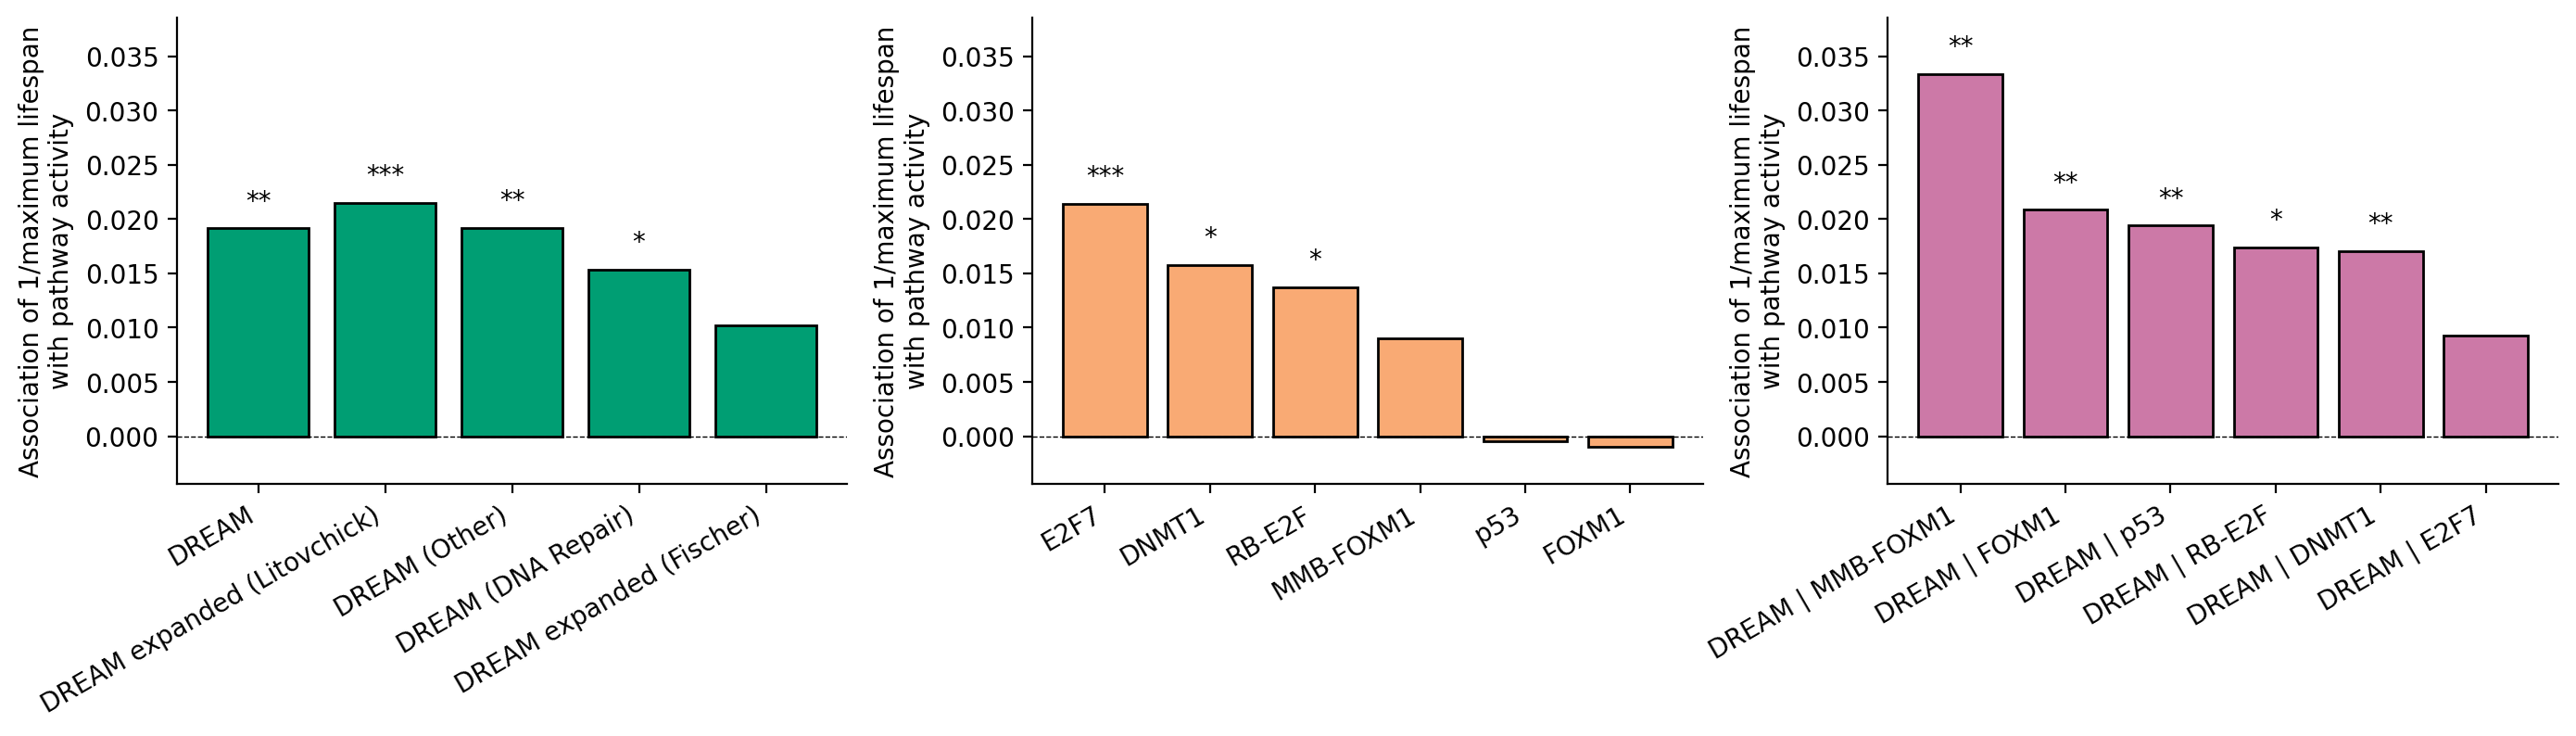

In [99]:
tissue = 'Liver'
# get rid of orders with only 1 species
num_species_in_order = liu_2023.dream_expression.query("Organ == @tissue").groupby("Order")['Common_name'].nunique().sort_values()
orders_to_use = num_species_in_order[num_species_in_order > 1].index
# get rid of species with less than 3 samples
num_samples_per_species = liu_2023.dream_expression.query("Organ == @tissue")['Common_name'].value_counts()
species_to_use = num_samples_per_species[num_samples_per_species >= 2].index
# remove Balaena_mysticetus from species_to_use
species_to_use = species_to_use[species_to_use != 'BowheadWhale']

# ols regression
results_long, results_wide = calc_aw_regression_association(
    liu_2023.dream_expression.query("Organ == @tissue and Order.isin(@orders_to_use) and Common_name.isin(@species_to_use)"),
    pathway_names = [
        'DREAM_normalized_enrichment_score_resid', 'DNMT1_NES_resid',
        'dream_dr_NES_resid', 'dream_other_NES_resid', 'E2F7_NES_resid',
        'FOXM1_NES_resid', 'dream_expanded_fischer_NES_resid',
        'dream_expanded_litovchick_NES_resid', 'mmb_foxm1_NES_resid',
        'p53_NES_resid', 'rb_e2f_NES_resid'
    ]
)

DREAM_pathways = [
    'DREAM_normalized_enrichment_score_resid',
    'dream_dr_NES_resid',
    'dream_other_NES_resid',
    'dream_expanded_fischer_NES_resid',
    'dream_expanded_litovchick_NES_resid',
]

solo_pathways = [
    'mmb_foxm1_NES_resid',
    'p53_NES_resid',
    'rb_e2f_NES_resid',
    'DNMT1_NES_resid',
    'E2F7_NES_resid',
    'FOXM1_NES_resid'
]

dream_combo_pathways = [
    'mmb_foxm1_NES_resid',
    'p53_NES_resid',
    'rb_e2f_NES_resid',
    'DNMT1_NES_resid',
    'E2F7_NES_resid',
    'FOXM1_NES_resid'
]
fig, axes = plot_dream_coefficients_barplot(
        results_long,
        dream_pathways=DREAM_pathways,
        solo_pathways=solo_pathways,
        dream_combo_pathways=dream_combo_pathways,
        organ='Liver'
    )
# angle x tick labels 60
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha = 'right')
plt.show()
fig.savefig('/cellar/users/zkoch/dream/figures/supplementary/revision_upset/cross_species_coefs.svg', dpi=300)


### Mouse lifespan

In [2]:
# Read lifespan data

# Load the data from the Excel file
file_path = "/cellar/users/zkoch/dream/data/williams_2022/aTableS1_AgingDB.xlsx"
survive_raw = pd.read_excel(file_path)

# select aniamls where the cause of death is natural or euth 
# and they are female
causes = ['Natural', 'Euthan']
survive = survive_raw.query("CauseOfDeath in @causes and Sex == 'F'").copy(deep = True)

# create indicator variable is death was observed
# this will be the inverse of AgeIfStillAlive2, which is 0 if the animal is still alive
survive['lifestatus'] = survive['AgeIfStillAlive2'].replace(0, 1)

loader = read_data.DatasetLoader('williams_2022')
williams = loader.load_dataset()

# drop rows with 0 total seq depth (these were not profiled for expression)
williams.calc_total_seq_depth()
williams.expression_df = williams.expression_df.query('total_seq_depth > 0')

# calculate mean dream
williams.get_dream_gene_expression()
# invert mean_dream_expression and scale to be positive, to match direction of mean_dream_reg_expr_resid
williams.dream_expression['mean_dream_reg_expr'] = -1 * williams.dream_expression['mean_dream_reg_expr']
williams.dream_expression['mean_dream_reg_expr'] = williams.dream_expression['mean_dream_reg_expr'] - williams.dream_expression['mean_dream_reg_expr'].min()

williams.dream_enrichment_ssgsea()

# invert DREAM_normalized_enrichment_score and scale to be positive, to match direction of DREAM_normalized_enrichment_score
williams.dream_expression['DREAM_normalized_enrichment_score'] = -1 * williams.dream_expression['DREAM_normalized_enrichment_score']
williams.dream_expression['DREAM_normalized_enrichment_score'] = williams.dream_expression['DREAM_normalized_enrichment_score'] - williams.dream_expression['DREAM_normalized_enrichment_score'].min()

# create strain to glasbey dark mapping
strains = list(set(survive['StrainNameCurrent'].unique().tolist()).union(set(williams.dream_expression['Strain3'].unique())))
strain_palette = dict(zip(strains, cc.glasbey_dark[:len(strains)]))

# find strains with inconsistent dream expression
dream_std_by_strain = williams.dream_expression.groupby(['Strain3', 'Diet3'])['DREAM_normalized_enrichment_score_resid'].std().reset_index()
dream_std_by_strain.columns = ['Strain3', 'Diet3', 'std']
# add counts to this
counts = williams.dream_expression.groupby(['Strain3', 'Diet3']).size().reset_index()
counts.columns = ['Strain3', 'Diet3', 'count']
# comnbine
dream_std_by_strain = dream_std_by_strain.merge(counts, on = ['Strain3', 'Diet3'])
# drop strain-diet pairs with stdev > 0.2
high_std = dream_std_by_strain.query('std > .2') 

# drop strains from survive that have high dream std 
survive = survive.query('StrainNameCurrent not in @high_std["Strain3"]')
williams.dream_expression = williams.dream_expression.query('Strain3 not in @high_std["Strain3"]')
williams.expression_df = williams.expression_df.query('Strain3 not in @high_std["Strain3"]')

williams.pathway_enrichment_ssgsea(
    gene_set_path='/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/DNMT1_targets.csv',
    pathway_name='DNMT1'
)
williams.pathway_enrichment_ssgsea(
    gene_set_path='/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/dream_dr.csv',
    pathway_name='dream_dr'
)
williams.pathway_enrichment_ssgsea(
    gene_set_path='/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/dream_other.csv',
    pathway_name='dream_other'
)
williams.pathway_enrichment_ssgsea(
    gene_set_path='/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/E2F7_targets.csv',
    pathway_name='E2F7'
)
williams.pathway_enrichment_ssgsea(
    gene_set_path='/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/FOXM1_targets.csv',
    pathway_name='FOXM1'
)
williams.pathway_enrichment_ssgsea(
    gene_set_path='/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/fischer_expanded_dream.csv',
    pathway_name='dream_expanded_fischer'
)
williams.pathway_enrichment_ssgsea(
    gene_set_path='/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/litovchick_expanded_dream.csv',
    pathway_name='dream_expanded_litovchick'
)
williams.pathway_enrichment_ssgsea(
    gene_set_path='/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/mmb_foxm1_targets.csv',
    pathway_name='mmb_foxm1'
)
williams.pathway_enrichment_ssgsea(
    gene_set_path='/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/p53_targets.csv',
    pathway_name='p53'
)
williams.pathway_enrichment_ssgsea(
    gene_set_path='/cellar/users/zkoch/dream/data/upsetplot_reviewer_sets/rb_e2f_targets.csv',
    pathway_name='rb_e2f'
)

/cellar/users/zkoch/dream/dream_proj_env3_uv/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Loading dataset: williams_2022


/cellar/users/zkoch/dream/source/read_data.py:1000: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,2

using new dream file:  False
Read in 328 DREAM genes
Converted DREAM genes to mouse genes
Found 291 DREAM genes with expression
scaled mean_dream_reg_expr by sequence depth and created mean_dream_reg_expr_resid
using new dream file:  False


2025-12-22 13:49:40,245 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:49:40,247 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:49:40,248 [INFO] Start to run ssGSEA...Might take a while................


scaled DREAM_normalized_enrichment_score by sequence depth and created DREAM_normalized_enrichment_score_resid
scaled DREAM_enrichment_score by sequence depth and created DREAM_enrichment_score_resid


2025-12-22 13:49:52,112 [INFO] Parsing data files for ssGSEA...........................


Found 86 DNMT1 genes with expression


2025-12-22 13:49:52,925 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:49:52,930 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:49:52,931 [INFO] Start to run ssGSEA...Might take a while................
2025-12-22 13:49:55,597 [INFO] Parsing data files for ssGSEA...........................


Scaled DNMT1_NES by sequence depth and created DNMT1_NES_resid
Scaled DNMT1_ES by sequence depth and created DNMT1_ES_resid
Found 66 dream_dr genes with expression


2025-12-22 13:49:56,422 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:49:56,425 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:49:56,426 [INFO] Start to run ssGSEA...Might take a while................


Scaled dream_dr_NES by sequence depth and created dream_dr_NES_resid
Scaled dream_dr_ES by sequence depth and created dream_dr_ES_resid


2025-12-22 13:49:59,346 [INFO] Parsing data files for ssGSEA...........................


Found 225 dream_other genes with expression


2025-12-22 13:50:00,173 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:50:00,175 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:50:00,176 [INFO] Start to run ssGSEA...Might take a while................
2025-12-22 13:50:02,798 [INFO] Parsing data files for ssGSEA...........................


Scaled dream_other_NES by sequence depth and created dream_other_NES_resid
Scaled dream_other_ES by sequence depth and created dream_other_ES_resid
Found 84 E2F7 genes with expression


2025-12-22 13:50:03,583 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:50:03,585 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:50:03,586 [INFO] Start to run ssGSEA...Might take a while................


Scaled E2F7_NES by sequence depth and created E2F7_NES_resid
Scaled E2F7_ES by sequence depth and created E2F7_ES_resid


2025-12-22 13:50:06,607 [INFO] Parsing data files for ssGSEA...........................


Found 233 FOXM1 genes with expression


2025-12-22 13:50:07,410 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:50:07,412 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:50:07,413 [INFO] Start to run ssGSEA...Might take a while................


Scaled FOXM1_NES by sequence depth and created FOXM1_NES_resid
Scaled FOXM1_ES by sequence depth and created FOXM1_ES_resid


2025-12-22 13:50:11,214 [INFO] Parsing data files for ssGSEA...........................


Found 917 dream_expanded_fischer genes with expression


2025-12-22 13:50:12,008 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:50:12,010 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:50:12,011 [INFO] Start to run ssGSEA...Might take a while................


Scaled dream_expanded_fischer_NES by sequence depth and created dream_expanded_fischer_NES_resid
Scaled dream_expanded_fischer_ES by sequence depth and created dream_expanded_fischer_ES_resid


2025-12-22 13:50:15,459 [INFO] Parsing data files for ssGSEA...........................


Found 470 dream_expanded_litovchick genes with expression


2025-12-22 13:50:16,277 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:50:16,279 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:50:16,281 [INFO] Start to run ssGSEA...Might take a while................


Scaled dream_expanded_litovchick_NES by sequence depth and created dream_expanded_litovchick_NES_resid
Scaled dream_expanded_litovchick_ES by sequence depth and created dream_expanded_litovchick_ES_resid


2025-12-22 13:50:19,531 [INFO] Parsing data files for ssGSEA...........................


Found 264 mmb_foxm1 genes with expression


2025-12-22 13:50:20,349 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:50:20,352 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:50:20,353 [INFO] Start to run ssGSEA...Might take a while................


Scaled mmb_foxm1_NES by sequence depth and created mmb_foxm1_NES_resid
Scaled mmb_foxm1_ES by sequence depth and created mmb_foxm1_ES_resid


2025-12-22 13:50:23,414 [INFO] Parsing data files for ssGSEA...........................


Found 296 p53 genes with expression


2025-12-22 13:50:24,239 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:50:24,241 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:50:24,242 [INFO] Start to run ssGSEA...Might take a while................


Scaled p53_NES by sequence depth and created p53_NES_resid
Scaled p53_ES by sequence depth and created p53_ES_resid


2025-12-22 13:50:27,610 [INFO] Parsing data files for ssGSEA...........................


Found 484 rb_e2f genes with expression


2025-12-22 13:50:28,449 [INFO] 0000 gene_sets have been filtered out when max_size=1000 and min_size=15
2025-12-22 13:50:28,451 [INFO] 0001 gene_sets used for further statistical testing.....
2025-12-22 13:50:28,453 [INFO] Start to run ssGSEA...Might take a while................


Scaled rb_e2f_NES by sequence depth and created rb_e2f_NES_resid
Scaled rb_e2f_ES by sequence depth and created rb_e2f_ES_resid


In [3]:
# choose which covariates to include
covariates_to_use = ['BodyWeight', 'LiverWeight', 'LiverWeight_PctBW',
       'HeartWeight', 'HeartWeight_PctBW', 'SpleenWeight', 'KidneysWeight',
       'PerirenalWATWeight', 'PerigonadalWATWeight', 'SubcutaneousWATWeight',
       'GastrocWeight', 'QuadricepsWeight', 'SoleusWeight',
       'HDL', 'LDL', 'TotalChol', 'ALT', 'ASAT',
       'ALToverASAT', 'Creatinine', 'CreatineKinase', 'Glucose', 'LDH',
       'Triglycerides', 'Bilirubin', 'FFA', 'BileAcids', 'Lactate', 'Protein',
       'ALPL', 'Iron', 'Amylase', 'total_seq_depth', 'n_genes_expressed', 'DREAM_normalized_enrichment_score', 'DREAM_normalized_enrichment_score_resid', 'mean_dream_reg_expr', 'mean_dream_reg_expr_resid']
#covariates_to_use = ['DREAM_normalized_enrichment_score', 'DREAM_normalized_enrichment_score_resid', 'mean_dream_reg_expr', 'mean_dream_reg_expr_resid']

# get mean of the covariates within each strain-diet group
mean_df = williams.dream_expression.groupby(
    ['Strain3', 'Diet3']
    )[covariates_to_use].mean()
mean_df.reset_index(inplace = True)
survive = survive.merge(mean_df, left_on = ['StrainNameCurrent', 'DietCode'], right_on = ['Strain3', 'Diet3'], how = 'left')
survive.dropna(subset = covariates_to_use, inplace = True)


In [4]:
def calc_pathway_hazard_ratios(
    survive_df: pd.DataFrame,
    williams_dream_expr: pd.DataFrame,
    pathway_names: list,
    dream_col: str = 'DREAM_normalized_enrichment_score_resid',
    duration_col: str = 'AgeAtDeath',
    event_col: str = 'lifestatus',
    base_covariates: list = None,
    phenotype_cols_for_pca: list = None,
    n_pcs: int = 3,
    strain_col: str = 'Strain3',
    diet_col: str = 'Diet3',
    survive_strain_col: str = 'StrainNameCurrent',
    survive_diet_col: str = 'DietCode',
    standardize: bool = True
) -> pd.DataFrame:
    """
    Calculate Cox proportional hazard ratios for pathway activities using a combined model
    with Diet interaction terms (Diet * Pathway).
    
    This matches the "both" model from the original implementation:
    - Uses ALL mice (both diets)
    - Fits model with Diet * Pathway interaction terms
    - Extracts diet-specific HRs from the interaction model
    
    The formula structure is:
        Diet * z_pathway + Diet * PC1 + Diet * z_total_seq_depth + Diet * z_WeightChangeBaseTo01
    
    Returns HRs for each pathway in each diet (HF and CD).
    """
    from lifelines import CoxPHFitter
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    if base_covariates is None:
        base_covariates = ['PC1', 'z_total_seq_depth', 'z_WeightChangeBaseTo01']

    if phenotype_cols_for_pca is None:
        phenotype_cols_for_pca = [
            'BodyWeight', 'LiverWeight', 'LiverWeight_PctBW',
            'HeartWeight', 'HeartWeight_PctBW', 'SpleenWeight', 'KidneysWeight',
            'PerirenalWATWeight', 'PerigonadalWATWeight', 'SubcutaneousWATWeight',
            'GastrocWeight', 'QuadricepsWeight', 'SoleusWeight',
            'HDL', 'LDL', 'TotalChol', 'ALT', 'ASAT',
            'ALToverASAT', 'Creatinine', 'CreatineKinase', 'Glucose', 'LDH',
            'Triglycerides', 'Bilirubin', 'FFA', 'BileAcids', 'Lactate', 'Protein',
            'ALPL', 'Iron', 'Amylase'
        ]

    # Filter to available pathways
    available_pathways = [p for p in pathway_names if p in williams_dream_expr.columns]
    if not available_pathways:
        raise ValueError("No valid pathway columns found in williams_dream_expr")

    # Get all columns we need from williams_dream_expr
    cols_to_aggregate = list(set(available_pathways + [dream_col, 'total_seq_depth']))
    cols_to_aggregate = [c for c in cols_to_aggregate if c in williams_dream_expr.columns]

    # STEP 1: Calculate mean pathway activities per strain-diet group
    mean_pathway_df = williams_dream_expr.groupby([strain_col, diet_col])[cols_to_aggregate].mean().reset_index()

    # STEP 2: Merge pathway means into survive_df
    merged_df = survive_df.copy()
    merged_df = merged_df.merge(
        mean_pathway_df,
        left_on=[survive_strain_col, survive_diet_col],
        right_on=[strain_col, diet_col],
        how='left',
        suffixes=('', '_pathway')
    )

    # Drop rows with missing pathway data
    key_cols = [dream_col] + available_pathways
    key_cols = [c for c in key_cols if c in merged_df.columns]
    merged_df = merged_df.dropna(subset=key_cols)

    if len(merged_df) == 0:
        raise ValueError("No data remaining after dropping NAs")

    # STEP 3: Compute PCA on phenotype columns for ALL data (both diets combined)
    if 'PC1' in base_covariates:
        available_pheno_cols = [c for c in phenotype_cols_for_pca if c in merged_df.columns]
        if len(available_pheno_cols) > 0:
            pheno_data = merged_df[available_pheno_cols].dropna()
            valid_idx = pheno_data.index

            scaler = StandardScaler()
            pheno_scaled = scaler.fit_transform(pheno_data)
            pca = PCA(n_components=n_pcs)
            pcs = pca.fit_transform(pheno_scaled)

            for i in range(n_pcs):
                merged_df.loc[valid_idx, f'PC{i+1}'] = pcs[:, i]

            merged_df = merged_df.loc[valid_idx].copy()

    # STEP 4: Z-score standardize across ALL data (both diets)
    if standardize:
        for pathway in available_pathways + [dream_col]:
            if pathway in merged_df.columns:
                col_mean = merged_df[pathway].mean()
                col_std = merged_df[pathway].std()
                if col_std > 0:
                    merged_df[f'z_{pathway}'] = (merged_df[pathway] - col_mean) / col_std
                else:
                    merged_df[f'z_{pathway}'] = 0

        if 'total_seq_depth' in merged_df.columns:
            col_mean = merged_df['total_seq_depth'].mean()
            col_std = merged_df['total_seq_depth'].std()
            if col_std > 0:
                merged_df['z_total_seq_depth'] = (merged_df['total_seq_depth'] - col_mean) / col_std

        if 'WeightChangeBaseTo01' in merged_df.columns:
            col_mean = merged_df['WeightChangeBaseTo01'].mean()
            col_std = merged_df['WeightChangeBaseTo01'].std()
            if col_std > 0:
                merged_df['z_WeightChangeBaseTo01'] = (merged_df['WeightChangeBaseTo01'] - col_mean) / col_std

    # Ensure Diet column exists for interaction model
    if diet_col not in merged_df.columns and survive_diet_col in merged_df.columns:
        merged_df[diet_col] = merged_df[survive_diet_col]

    # STEP 5: Explicitly set CD as the baseline/reference group for Diet
    # Convert Diet column to categorical with CD as the first category (reference)
    if diet_col in merged_df.columns:
        diet_categories = merged_df[diet_col].unique().tolist()
        # Ensure CD comes first (as reference category)
        if 'CD' in diet_categories:
            diet_categories.remove('CD')
            diet_categories = ['CD'] + diet_categories
        merged_df[diet_col] = pd.Categorical(merged_df[diet_col], categories=diet_categories, ordered=False)

    results = []

    def z_col(col):
        return f'z_{col}' if standardize else col

    available_base_covs = [c for c in base_covariates if c in merged_df.columns]

    for pathway in available_pathways:
        pathway_z = z_col(pathway)
        dream_z = z_col(dream_col)

        if pathway_z not in merged_df.columns:
            continue

        # Build interaction formula: Diet * pathway + Diet * covariates
        interaction_terms = [f'{diet_col} * {pathway_z}']
        for cov in available_base_covs:
            interaction_terms.append(f'{diet_col} * {cov}')
        
        formula_interaction = ' + '.join(interaction_terms)

        # Columns needed for the model
        cols_needed = [duration_col, event_col, pathway_z, diet_col] + available_base_covs

        try:
            cph = CoxPHFitter()
            cph.fit(
                merged_df[cols_needed].dropna(),
                duration_col=duration_col,
                event_col=event_col,
                formula=formula_interaction,
                show_progress=False
            )


            # Extract coefficients from the interaction model
            # The model has terms like:
            # - Diet3[T.HF] (diet main effect)
            # - z_pathway (CD baseline effect for pathway)
            # - Diet3[T.HF]:z_pathway (HF-specific additional effect)
            # 
            # HR for CD = exp(coef of z_pathway)
            # HR for HF = exp(coef of z_pathway + coef of Diet3[T.HF]:z_pathway)

            summary = cph.summary
            
            # Find the pathway coefficient (baseline, which is CD)
            pathway_coef_cd = cph.params_[pathway_z]
            pathway_ci_lower_cd = cph.confidence_intervals_.loc[pathway_z, '95% lower-bound']
            pathway_ci_upper_cd = cph.confidence_intervals_.loc[pathway_z, '95% upper-bound']
            pathway_pval_cd = summary.loc[pathway_z, 'p']

            # Find the interaction term for HF
            interaction_term = f'{diet_col}[T.HF]:{pathway_z}'
            if interaction_term in cph.params_.index:
                interaction_coef = cph.params_[interaction_term]
                interaction_pval = summary.loc[interaction_term, 'p']
                
                # HF coefficient = baseline + interaction
                pathway_coef_hf = pathway_coef_cd + interaction_coef
                
                # For HF CI and p-value, we use the interaction term's statistics
                # (This is an approximation - proper CI would need variance-covariance)
                pathway_ci_lower_hf = cph.confidence_intervals_.loc[interaction_term, '95% lower-bound'] + pathway_coef_cd
                pathway_ci_upper_hf = cph.confidence_intervals_.loc[interaction_term, '95% upper-bound'] + pathway_coef_cd
                pathway_pval_hf = interaction_pval
            else:
                # If no interaction term found, use baseline for both
                pathway_coef_hf = pathway_coef_cd
                pathway_ci_lower_hf = pathway_ci_lower_cd
                pathway_ci_upper_hf = pathway_ci_upper_cd
                pathway_pval_hf = pathway_pval_cd

            # Calculate HRs
            hr_cd = np.exp(pathway_coef_cd)
            hr_hf = np.exp(pathway_coef_hf)
            ci_lower_cd = np.exp(pathway_ci_lower_cd)
            ci_upper_cd = np.exp(pathway_ci_upper_cd)
            ci_lower_hf = np.exp(pathway_ci_lower_hf)
            ci_upper_hf = np.exp(pathway_ci_upper_hf)

            # Store CD results
            results.append({
                'pathway': pathway,
                'model_type': 'interaction',
                'extracted_variable': pathway,
                'hazard_ratio': hr_cd,
                'ci_lower': ci_lower_cd,
                'ci_upper': ci_upper_cd,
                'pvalue': pathway_pval_cd,
                'coefficient': pathway_coef_cd,
                'diet': 'CD',
                'formula': formula_interaction
            })

            # Store HF results
            results.append({
                'pathway': pathway,
                'model_type': 'interaction',
                'extracted_variable': pathway,
                'hazard_ratio': hr_hf,
                'ci_lower': ci_lower_hf,
                'ci_upper': ci_upper_hf,
                'pvalue': pathway_pval_hf,
                'coefficient': pathway_coef_hf,
                'diet': 'HF',
                'formula': formula_interaction
            })



        except Exception as e:
            print(f"Warning: Interaction model failed for {pathway}: {e}")
            # Add NaN results for both diets
            for diet in ['CD', 'HF']:
                results.append({
                    'pathway': pathway,
                    'model_type': 'interaction',
                    'extracted_variable': pathway,
                    'hazard_ratio': np.nan,
                    'ci_lower': np.nan,
                    'ci_upper': np.nan,
                    'pvalue': np.nan,
                    'coefficient': np.nan,
                    'diet': diet,
                    'formula': formula_interaction
                })

        # Model 2: DREAM + pathway with interaction (extract DREAM coefficient)
        if pathway != dream_col and dream_z in merged_df.columns:
            interaction_terms_combo = [f'{diet_col} * {dream_z}', f'{diet_col} * {pathway_z}']
            for cov in available_base_covs:
                interaction_terms_combo.append(f'{diet_col} * {cov}')
            
            formula_combo = ' + '.join(interaction_terms_combo)
            cols_needed_combo = [duration_col, event_col, dream_z, pathway_z, diet_col] + available_base_covs

            try:
                cph_combo = CoxPHFitter()
                cph_combo.fit(
                    merged_df[cols_needed_combo].dropna(),
                    duration_col=duration_col,
                    event_col=event_col,
                    formula=formula_combo,
                    show_progress=False
                )

                summary_combo = cph_combo.summary

                # Extract DREAM coefficients
                dream_coef_cd = cph_combo.params_[dream_z]
                dream_ci_lower_cd = cph_combo.confidence_intervals_.loc[dream_z, '95% lower-bound']
                dream_ci_upper_cd = cph_combo.confidence_intervals_.loc[dream_z, '95% upper-bound']
                dream_pval_cd = summary_combo.loc[dream_z, 'p']

                interaction_term_dream = f'{diet_col}[T.HF]:{dream_z}'
                if interaction_term_dream in cph_combo.params_.index:
                    dream_interaction_coef = cph_combo.params_[interaction_term_dream]
                    dream_interaction_pval = summary_combo.loc[interaction_term_dream, 'p']
                    
                    dream_coef_hf = dream_coef_cd + dream_interaction_coef
                    dream_ci_lower_hf = cph_combo.confidence_intervals_.loc[interaction_term_dream, '95% lower-bound'] + dream_coef_cd
                    dream_ci_upper_hf = cph_combo.confidence_intervals_.loc[interaction_term_dream, '95% upper-bound'] + dream_coef_cd
                    dream_pval_hf = dream_interaction_pval
                else:
                    dream_coef_hf = dream_coef_cd
                    dream_ci_lower_hf = dream_ci_lower_cd
                    dream_ci_upper_hf = dream_ci_upper_cd
                    dream_pval_hf = dream_pval_cd

                # Store results for DREAM when controlling for this pathway
                results.append({
                    'pathway': pathway,
                    'model_type': 'with_DREAM',
                    'extracted_variable': dream_col,
                    'hazard_ratio': np.exp(dream_coef_cd),
                    'ci_lower': np.exp(dream_ci_lower_cd),
                    'ci_upper': np.exp(dream_ci_upper_cd),
                    'pvalue': dream_pval_cd,
                    'coefficient': dream_coef_cd,
                    'diet': 'CD',
                    'formula': formula_combo
                })

                results.append({
                    'pathway': pathway,
                    'model_type': 'with_DREAM',
                    'extracted_variable': dream_col,
                    'hazard_ratio': np.exp(dream_coef_hf),
                    'ci_lower': np.exp(dream_ci_lower_hf),
                    'ci_upper': np.exp(dream_ci_upper_hf),
                    'pvalue': dream_pval_hf,
                    'coefficient': dream_coef_hf,
                    'diet': 'HF',
                    'formula': formula_combo
                })

            except Exception as e:
                print(f"Warning: Combo interaction model failed for {pathway}: {e}")
                for diet in ['CD', 'HF']:
                    results.append({
                        'pathway': pathway,
                        'model_type': 'with_DREAM',
                        'extracted_variable': dream_col,
                        'hazard_ratio': np.nan,
                        'ci_lower': np.nan,
                        'ci_upper': np.nan,
                        'pvalue': np.nan,
                        'coefficient': np.nan,
                        'diet': diet,
                        'formula': formula_combo
                    })

    results_df = pd.DataFrame(results)

    def clean_name(name):
        return (
            name
            .replace('_NES_resid', '')
            .replace('_normalized_enrichment_score_resid', '')
            .replace('_', ' ')
        )

    results_df['pathway_clean'] = results_df['pathway'].apply(clean_name)

    return results_df


from matplotlib.lines import Line2D


def plot_hazard_ratio_pointplot(
    hr_results: pd.DataFrame,
    dream_pathways: list = None,
    solo_pathways: list = None,
    dream_combo_pathways: list = None,
    figsize: tuple = (14, 5),
    title: str = None,
    diet: str = None,
    hr_col: str = 'hazard_ratio',
    ci_lower_col: str = 'ci_lower',
    ci_upper_col: str = 'ci_upper',
    pvalue_col: str = 'pvalue',
    pathway_col: str = 'pathway',
    model_type_col: str = 'model_type',
    significance_threshold: float = 0.05,
    colors: dict = None
):
    """
    Plot hazard ratios with confidence intervals as a point plot.
    Each pathway category is plotted on its own axes (3 axes side by side).
    """

    # Default colors
    if colors is None:
        colors = {
            'dream': my_categorical_palette[0],
            'solo': my_categorical_palette[1],
            'combo': my_categorical_palette[2]
        }

    df = hr_results.copy()
    if diet is not None:
        df = df[df['diet'] == diet]

    def get_clean_name(pathway):
        # map pathways to their cleaned names
        mapper = {
            'DREAM_normalized_enrichment_score_resid': 'DREAM',
            'DNMT1_NES_resid': 'DNMT1',
            'dream_dr_NES_resid': 'DREAM (DNA Repair)', 
            'dream_other_NES_resid': 'DREAM (Other)', 
            'E2F7_NES_resid': 'E2F7',
            'FOXM1_NES_resid': 'FOXM1', 
            'dream_expanded_fischer_NES_resid': 'DREAM expanded (Fischer)',
            'dream_expanded_litovchick_NES_resid': 'DREAM expanded (Litovchick)', 
            'mmb_foxm1_NES_resid': 'MMB-FOXM1',
            'p53_NES_resid': 'p53', 
            'rb_e2f_NES_resid': 'RB-E2F'
        }
        return mapper[pathway]
        
    # Use 'interaction' or 'solo' model type
    model_types_to_check = ['interaction', 'solo']

    # Collect data for each category separately
    dream_data = []
    solo_data = []
    combo_data = []

    if dream_pathways:
        for pathway in dream_pathways:
            for mt in model_types_to_check:
                mask = (df[pathway_col] == pathway) & (df[model_type_col] == mt)
                rows = df[mask]
                if len(rows) > 0:
                    row = rows.iloc[0]
                    dream_data.append({
                        'pathway': get_clean_name(pathway),
                        'hr': row[hr_col],
                        'ci_lower': row[ci_lower_col],
                        'ci_upper': row[ci_upper_col],
                        'pvalue': row[pvalue_col],
                        'color': colors['dream']
                    })
                    break

    if solo_pathways:
        for pathway in solo_pathways:
            for mt in model_types_to_check:
                mask = (df[pathway_col] == pathway) & (df[model_type_col] == mt)
                rows = df[mask]
                if len(rows) > 0:
                    row = rows.iloc[0]
                    solo_data.append({
                        'pathway': get_clean_name(pathway),
                        'hr': row[hr_col],
                        'ci_lower': row[ci_lower_col],
                        'ci_upper': row[ci_upper_col],
                        'pvalue': row[pvalue_col],
                        'color': colors['solo']
                    })
                    break

    if dream_combo_pathways:
        for pathway in dream_combo_pathways:
            mask = (df[pathway_col] == pathway) & (df[model_type_col] == 'with_DREAM')
            rows = df[mask]
            if len(rows) > 0:
                row = rows.iloc[0]
                combo_data.append({
                    'pathway': f"DREAM | {get_clean_name(pathway)}",
                    'hr': row[hr_col],
                    'ci_lower': row[ci_lower_col],
                    'ci_upper': row[ci_upper_col],
                    'pvalue': row[pvalue_col],
                    'color': colors['combo']
                })

    if not dream_data and not solo_data and not combo_data:
        print("No data to plot!")
        return None, None

    # Convert to DataFrames and sort
    dream_df = pd.DataFrame(dream_data).sort_values('hr', ascending=True) if dream_data else pd.DataFrame()
    solo_df = pd.DataFrame(solo_data).sort_values('hr', ascending=True) if solo_data else pd.DataFrame()
    combo_df = pd.DataFrame(combo_data).sort_values('hr', ascending=True) if combo_data else pd.DataFrame()

    # Calculate shared y-axis range
    all_data = pd.concat([dream_df, solo_df, combo_df], ignore_index=True)
    y_min = all_data['ci_lower'].min() - 0.1
    y_max = all_data['ci_upper'].max() + 0.15  # Extra space for significance stars

    # Determine widths for each subplot based on number of items
    n_dream = len(dream_df) if len(dream_df) > 0 else 0
    n_solo = len(solo_df) if len(solo_df) > 0 else 0
    n_combo = len(combo_df) if len(combo_df) > 0 else 0
    
    fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=False)

    

    def plot_on_axis(ax, plot_df, category_title, color):
        if len(plot_df) == 0:
            return
        
        plot_df = plot_df.reset_index(drop=True)
        plot_df['x_pos'] = range(len(plot_df))

        for idx, row in plot_df.iterrows():
            x = row['x_pos']
            ax.errorbar(
                x, row['hr'],
                yerr=[[row['hr'] - row['ci_lower']], [row['ci_upper'] - row['hr']]],
                fmt='o',
                color=row['color'],
                markersize=8,
                capsize=4,
                capthick=1.5,
                elinewidth=1.5,
                markeredgecolor='white',
                markeredgewidth=0.5
            )
            if pd.notna(row['pvalue']):
                if row['pvalue'] < 0.001:
                    stars = '***'
                elif row['pvalue'] < 0.01:
                    stars = '**'
                elif row['pvalue'] < significance_threshold:
                    stars = '*'
                else:
                    stars = None
                
                if stars:
                    ax.annotate(
                        stars,
                        (x, row['ci_upper'] + 0.02),
                        fontsize=14,
                        color='black',
                        ha='center',
                        va='bottom'
                    )

        ax.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.7)
        ax.set_xticks(plot_df['x_pos'])
        ax.set_xticklabels(plot_df['pathway'], rotation=45, ha='right')
        ax.set_ylim(y_min, y_max)

    # Plot each category on its own axis
    ax_idx = 0
    if n_dream > 0:
        plot_on_axis(axes[ax_idx], dream_df, 'DREAM Pathways', colors['dream'])
        axes[ax_idx].set_ylabel('Hazard Ratio', fontsize=12)
        ax_idx += 1
    if n_solo > 0:
        plot_on_axis(axes[ax_idx], solo_df, 'Other Pathways (Solo)', colors['solo'])
        ax_idx += 1
    if n_combo > 0:
        plot_on_axis(axes[ax_idx], combo_df, 'DREAM (Controlling for Other)', colors['combo'])
        ax_idx += 1

    sns.despine()
    # remove grid lines
    for axs in axes:
        axs.grid(False)

    plt.tight_layout()

    return fig, axes

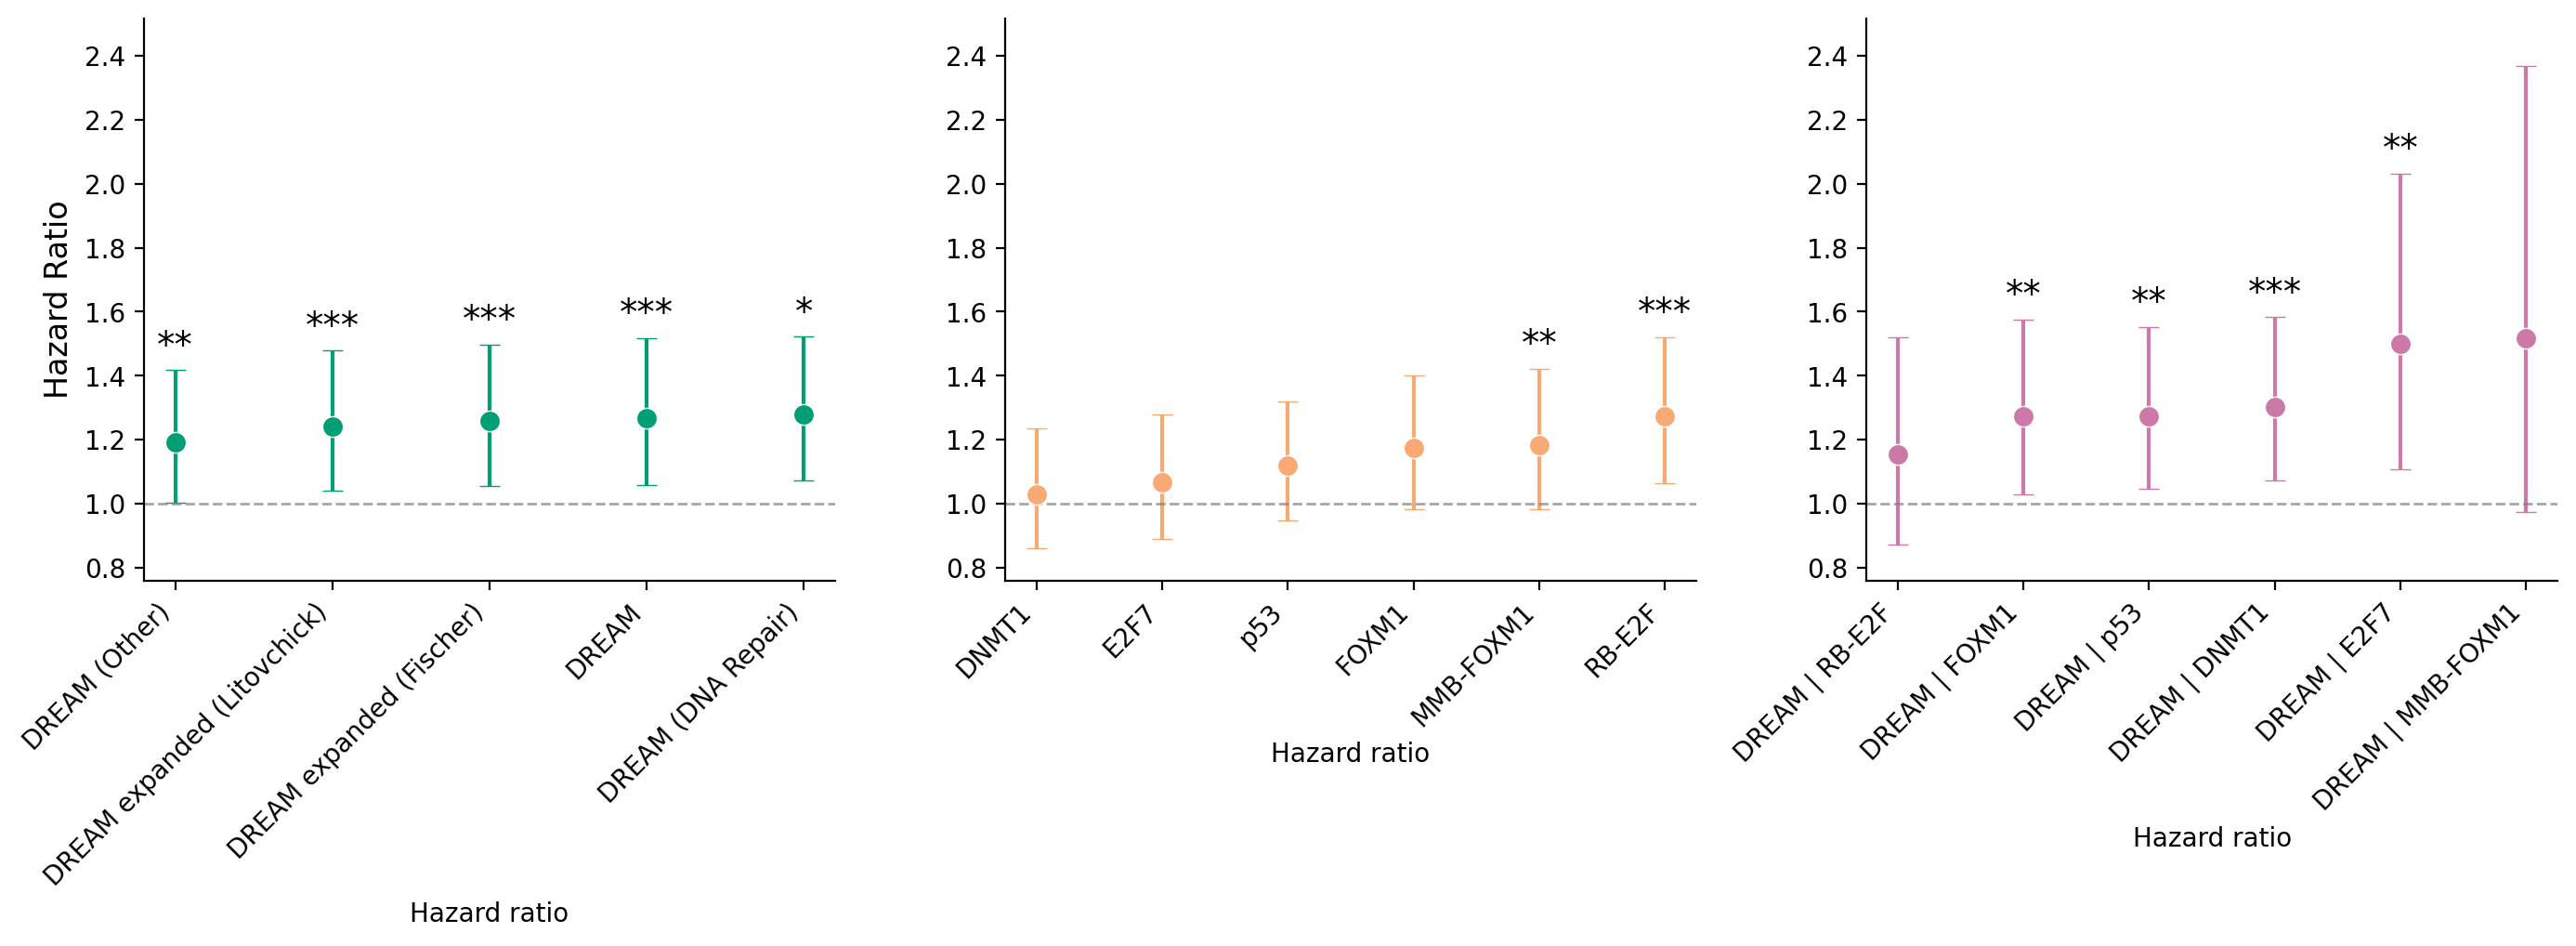

In [5]:
# Define pathways to analyze
pathway_names_for_hr = [
    'DREAM_normalized_enrichment_score_resid',
    'DNMT1_NES_resid',
    'dream_dr_NES_resid', 
    'dream_other_NES_resid', 
    'E2F7_NES_resid',
    'FOXM1_NES_resid', 
    'dream_expanded_fischer_NES_resid',
    'dream_expanded_litovchick_NES_resid', 
    'mmb_foxm1_NES_resid',
    'p53_NES_resid', 
    'rb_e2f_NES_resid'
]

# Calculate HRs using the interaction model (returns results for both diets)
hr_results_combined = calc_pathway_hazard_ratios(
    survive_df=survive,
    williams_dream_expr=williams.dream_expression,
    pathway_names=pathway_names_for_hr
)


# Define pathway groups
DREAM_pathways = [
    'DREAM_normalized_enrichment_score_resid',
    'dream_dr_NES_resid',
    'dream_other_NES_resid',
    'dream_expanded_fischer_NES_resid',
    'dream_expanded_litovchick_NES_resid',
]

solo_pathways = [
    'mmb_foxm1_NES_resid',
    'p53_NES_resid',
    'rb_e2f_NES_resid',
    'DNMT1_NES_resid',
    'E2F7_NES_resid',
    'FOXM1_NES_resid'
]

dream_combo_pathways = [
    'mmb_foxm1_NES_resid',
    'p53_NES_resid',
    'rb_e2f_NES_resid',
    'DNMT1_NES_resid',
    'E2F7_NES_resid',
    'FOXM1_NES_resid'
]

# Plot for HF diet
fig, ax = plot_hazard_ratio_pointplot(
    hr_results_combined,
    dream_pathways=DREAM_pathways,
    solo_pathways=solo_pathways,
    dream_combo_pathways=dream_combo_pathways,
    diet='HF',
    title='Hazard Ratios for Pathway Activities (HF Diet) - Interaction Model'
)
for a in ax:
    a.set_xlabel('Hazard ratio')
plt.show()
# save as svg
fig.savefig('/cellar/users/zkoch/dream/figures/supplementary/revision_upset/mouse_lifespan_hrs.svg', dpi=300)
